In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt

### Get synthetic data

In [2]:
np.random.seed(1)
A = np.asarray([np.random.beta(2.0,5.0,20) for _ in range(10000)])
B = np.asarray([np.random.beta(2.0,5.0,20) for _ in range(10000)])
bins = 200

# Run parallelized version of the Shift-method

In [3]:
start = time.time()
SGM = significance_of_mean_cuda(bins,dtype_v=np.uint16,dtype_A=np.uint32)
PC = SGM.run(A,B)
end = time.time()
print(end - start)

14.397771835327148


# Run regular non-parallelized version but parallelize over samples

In [4]:
multiprocessing.cpu_count()

6

#### The calculations are parallelized over the samples on five cores in total. 

In [5]:
def p_value_calc(args):
    a,b = args
    p=significance_of_mean(a,b, bins)[0]
    return p

def calibration_series_generator(A,B):
    num_tests = A.shape[0]
    for i in range(num_tests):
        a_sample = A[i].tolist()
        b_sample = B[i].tolist()
        yield ([a_sample,b_sample])

def calibration_test(A,B):
    with cf.ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()-1) as pool:
        p_list = list(pool.map(p_value_calc, calibration_series_generator(A,B)))
    return p_list

In [6]:
start = time.time()
P = list()
P = calibration_test(A,B)
end = time.time()
print(end - start)

107.3141598701477


### The parallelized version is faster and yields the same p-values 

In [7]:
np.allclose(PC,P)

True

### Comparison of increasing sample sizes. Sample-sizes larger than 160 yields memory error on the non-parallelized version, so the experiment stops there.

In [8]:
listsizes = [20,60,120,160]
plain_shift = list()
gpu_shift = list()
bins = 200
for size in listsizes:
    np.random.seed(1)
    A = np.asarray([np.random.beta(2.0,5.0,size) for _ in range(5)])
    B = np.asarray([np.random.beta(2.0,5.0,size) for _ in range(5)])
    start = time.time()
    P = calibration_test(A,B)
    end = time.time()
    plain_shift.append(round(end - start,3))
    print("Plain")
    print(round(end - start,3))
    
    start = time.time()
    SGM = significance_of_mean_cuda(bins,dtype_v=np.uint32,dtype_A=np.float64)
    PC = SGM.run(A,B)
    end = time.time()
    end = time.time()
    gpu_shift.append(round(end - start,3))
    print("GPU")
    print(round(end - start,3))
    
    print(np.allclose(PC,P))

Plain
0.176
GPU
0.027
True
Plain
1.939
GPU
0.105
True
Plain
20.915
GPU
0.885
True
Plain
54.211
GPU
2.096
True


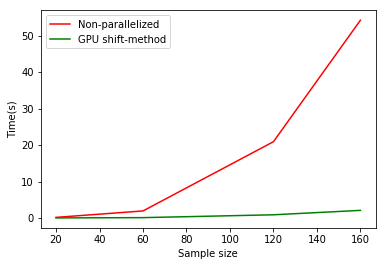

In [10]:
plt.plot(listsizes, plain_shift, 'r-', label='Non-parallelized')
plt.plot(listsizes, gpu_shift, 'g-', label='GPU shift-method')
plt.legend(loc='upper left')
plt.xlabel("Sample size")
plt.ylabel("Time(s)")
plt.savefig("figures/comparison")
plt.show()